## Example with PRISM Data from lecture

In [24]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d

In [40]:
## April 1st 2018 precipitation
raster_file = '/Users/noahgonzales/Desktop/PRISM Data/PRISM_ppt_stable_4kmD2_20180401_bil.bil'

In [42]:
raster = rasterio.open(raster_file)

In [4]:
raster.read().shape

(1, 621, 1405)

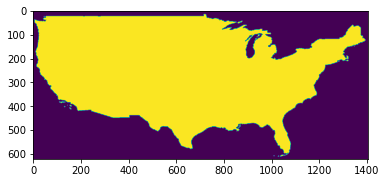

In [5]:
plt.imshow(raster.read()[0,:,:])

In [43]:
state_file = '/Users/noahgonzales/Desktop/us_states.json'

In [44]:
country = geopandas.read_file(state_file)

In [45]:
country.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [46]:
country_proj = country.to_crs(epsg=4269) 

In [47]:
raster.crs == country_proj.crs

True

In [48]:
country = country_proj[(country.NAME!="Alaska")&\
                  (country.NAME!="Hawaii")&\
                  (country.NAME!="Puerto Rico")]

<AxesSubplot:>

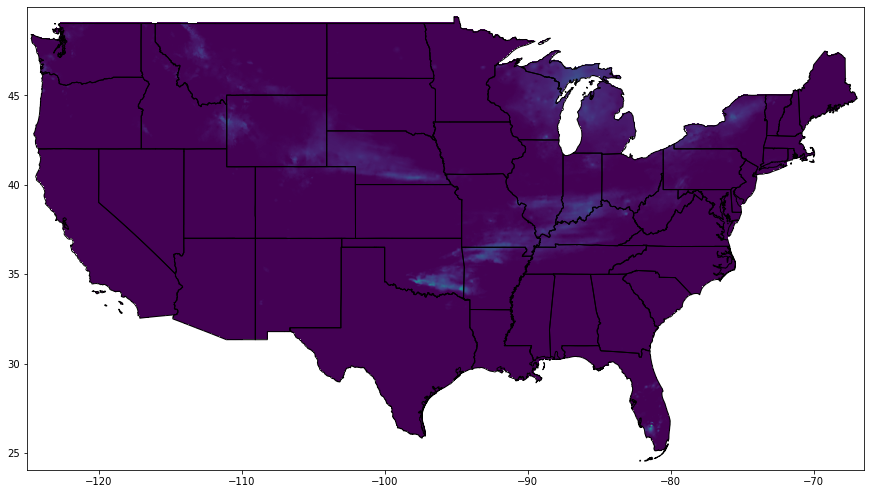

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(raster, ax=ax)
country.plot(ax=ax, facecolor='none', edgecolor='black')

In [50]:
import json

json.loads(country[country.NAME=="Illinois"]["geometry"].to_json())["features"][0]["geometry"]

{'type': 'Polygon',
 'coordinates': [[[-89.36603114883474, 42.50027398148966],
   [-89.36156114818282, 42.50001198061909],
   [-89.29089613786661, 42.498852965512626],
   [-89.25075913201022, 42.4979939570275],
   [-89.2469721315942, 42.49812995614603],
   [-89.22827912968691, 42.49804695221795],
   [-89.22627012948044, 42.49795695183703],
   [-89.16672812340477, 42.49725593954238],
   [-89.16490512322002, 42.49734693910924],
   [-89.12511111916616, 42.49695693084902],
   [-89.12036511868324, 42.49699192982299],
   [-89.11694911833534, 42.49690992913798],
   [-89.09901211650987, 42.49649892553045],
   [-89.0711411136763, 42.496207919750375],
   [-89.04289811080456, 42.496254913723476],
   [-89.01380410784844, 42.49609690761619],
   [-89.01366710783465, 42.49608690759196],
   [-88.99297710638028, 42.496025903371624],
   [-88.99265910637732, 42.49602490331123],
   [-88.94326410593399, 42.49511389429362],
   [-88.940391105909, 42.495045893776116],
   [-88.94038810590895, 42.49504589377554

In [14]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

IL_coords = getFeatures(country[country.NAME=="Illinois"])

In [15]:
IL_coords;

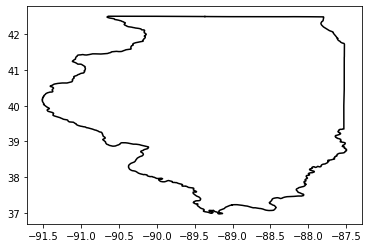

In [16]:
coords = np.array(IL_coords[0]['coordinates'][0])
plt.plot(coords[:,0],coords[:,1],color='black')

In [17]:
from rasterio.mask import mask

img_out, img_transform = mask(raster,IL_coords)

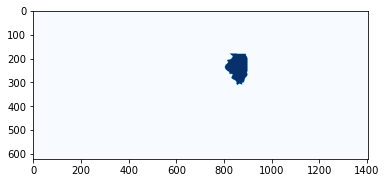

In [18]:
plt.imshow(img_out[0],cmap="Blues")

In [19]:
img_transform

Affine(0.0416666666667, 0.0, -125.02083333333336,
       0.0, -0.0416666666667, 49.93749999999975)

In [20]:
out_meta = raster.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = img_transform

with rasterio.open("./IL_PPT.tif1", "w", **out_meta) as dest:
    dest.write(img_out)

In [21]:
IL_raster = rasterio.open("./IL_PPT.tif1")

<AxesSubplot:>

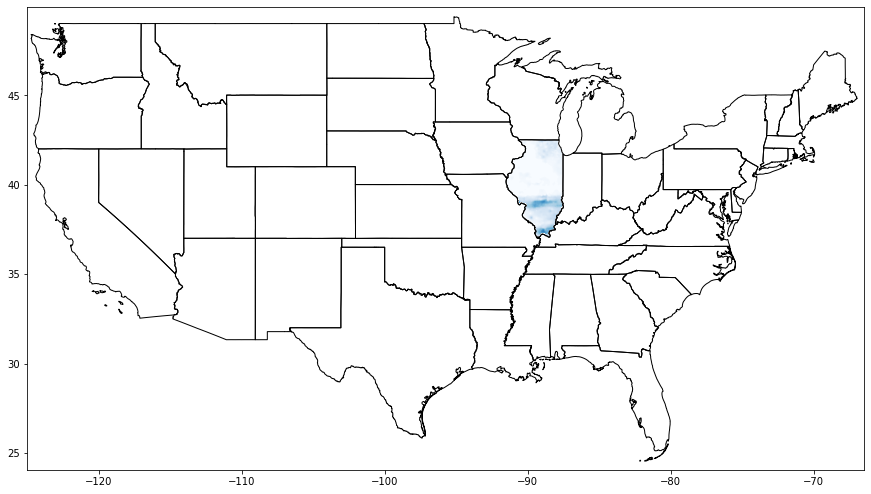

In [22]:
from rasterio.plot import show

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(IL_raster, ax=ax,cmap="Blues")
country.plot(ax=ax, facecolor='none', edgecolor='black')

In [17]:
import pandas as pd

In [24]:
IL_vals = pd.Series(IL_raster.read(1).flatten())

In [25]:
IL_avg = IL_vals[IL_vals!=-9999].describe()['mean']

In [26]:
IL_r_vals = IL_raster.read(1)

In [27]:
img_out = (IL_r_vals>IL_avg)[np.newaxis, :, :].astype(np.float32)

In [28]:
out_meta = IL_raster.meta.copy()
    
out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = img_transform
    
with rasterio.open("./example.tif", "w", **out_meta) as dest:
        dest.write(img_out)

In [18]:

from rasterstats import zonal_stats

zonal_stats(country, '/Users/noahgonzales/Desktop/PRISM Data/PRISM_ppt_stable_4kmD2_20180401_bil.bil')

[{'min': 0.0,
  'max': 0.6269999742507935,
  'mean': 0.0013101316850309057,
  'count': 7442},
 {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'count': 16631},
 {'min': 0.0,
  'max': 22.743999481201172,
  'mean': 2.234500310003865,
  'count': 7762},
 {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'count': 24009},
 {'min': 0.0,
  'max': 8.694999694824219,
  'mean': 0.3014932967266858,
  'count': 16224},
 {'min': 0.0,
  'max': 2.1610000133514404,
  'mean': 0.21616415152872415,
  'count': 798},
 {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'count': 317},
 {'min': 0.0,
  'max': 1.0180000066757202,
  'mean': 0.20972726561806418,
  'count': 11},
 {'min': 0.0,
  'max': 68.65899658203125,
  'mean': 0.5031743176300125,
  'count': 7980},
 {'min': 0.0,
  'max': 0.7910000085830688,
  'mean': 0.0010395593359672837,
  'count': 8443},
 {'min': 0.0,
  'max': 16.312000274658203,
  'mean': 0.3987282890469505,
  'count': 14068},
 {'min': 0.0,
  'max': 16.427000045776367,
  'mean': 1.5398230253811747,
  'count': 8887},
 {'min': 0.

In [19]:
import pandas as pd
rain_stats = pd.DataFrame(zonal_stats(country, '/Users/noahgonzales/Desktop/PRISM Data/PRISM_ppt_stable_4kmD2_20180401_bil.bil'))

In [31]:
rain_stats.shape

(49, 4)

In [32]:
rain_stats.columns = ["rain_"+x for x in rain_stats.columns]

rain_stats.index = country.index

country_rain = pd.concat([country,rain_stats],axis=1)

In [50]:
country_rain ## April 1st 2018 Data

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,rain_min,rain_max,rain_mean,rain_count
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28365, -88.08681 ...",0.000,0.627000,0.001310,7442
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",0.000,0.000000,0.000000,16631
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04303 33.079...",0.000,22.743999,2.234500,7762
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",0.000,0.000000,0.000000,24009
5,0400000US08,08,Colorado,,103641.888,"POLYGON ((-106.19055 40.99761, -106.06118 40.9...",0.000,8.695000,0.301493,16224
6,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-71.79924 42.00807, -71.79792 41.935...",0.000,2.161000,0.216164,798
7,0400000US10,10,Delaware,,1948.543,"MULTIPOLYGON (((-75.56493 39.58325, -75.57627 ...",0.000,0.000000,0.000000,317
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03860 38.79151, -77.03890 38.800...",0.000,1.018000,0.209727,11
9,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-82.82159 27.96445, -82.82980 ...",0.000,68.658997,0.503174,7980
10,0400000US13,13,Georgia,,57513.485,"POLYGON ((-84.81048 34.98761, -84.80919 34.987...",0.000,0.791000,0.001040,8443


## Zonal Stats with monthly data from 2019 -  Need to figure out how to get each month

In [51]:
## This is suppsoe to be monthly precipitation data for 2019
raster_2019 = '/Users/noahgonzales/Desktop/2019 Monthly Data/PRISM_ppt_stable_4kmM3_2019_bil.bil'

In [52]:
zonal_stats(country, '/Users/noahgonzales/Desktop/2019 Monthly Data/PRISM_ppt_stable_4kmM3_2019_bil.bil')

[{'min': 911.7078857421875,
  'max': 2208.56005859375,
  'mean': 1542.1014512227896,
  'count': 7442},
 {'min': 66.8438949584961,
  'max': 1236.846923828125,
  'mean': 367.75242017918345,
  'count': 16631},
 {'min': 1213.50390625,
  'max': 2232.14404296875,
  'mean': 1720.1826848750322,
  'count': 7762},
 {'min': 72.52389526367188,
  'max': 4544.30078125,
  'mean': 776.2788121121246,
  'count': 24009},
 {'min': 170.10189819335938,
  'max': 1867.0487060546875,
  'mean': 506.20152243589746,
  'count': 16224},
 {'min': 1229.4208984375,
  'max': 1669.85595703125,
  'mean': 1444.7628446115289,
  'count': 798},
 {'min': 1004.6489868164062,
  'max': 1362.880859375,
  'mean': 1179.1325906940062,
  'count': 317},
 {'min': 1102.3348388671875,
  'max': 1208.347900390625,
  'mean': 1164.7212357954545,
  'count': 11},
 {'min': 800.3009033203125,
  'max': 2603.304931640625,
  'mean': 1439.2124060150377,
  'count': 7980},
 {'min': 837.9649047851562,
  'max': 2544.745849609375,
  'mean': 1265.80315053

In [53]:
rain_stats_2019 = pd.DataFrame(zonal_stats(country, '/Users/noahgonzales/Desktop/2019 Monthly Data/PRISM_ppt_stable_4kmM3_2019_bil.bil'))

In [37]:
rain_stats_2019.columns = ["rain_"+x for x in rain_stats_2019.columns]

rain_stats_2019.index = country.index

country_rain_2019 = pd.concat([country,rain_stats_2019],axis=1)

In [38]:
country_rain_2019 ## Need to figure out how to get each month in DataFrame

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,rain_min,rain_max,rain_mean,rain_count
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28365, -88.08681 ...",911.707886,2208.560059,1542.101451,7442
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",66.843895,1236.846924,367.752420,16631
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04303 33.079...",1213.503906,2232.144043,1720.182685,7762
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",72.523895,4544.300781,776.278812,24009
5,0400000US08,08,Colorado,,103641.888,"POLYGON ((-106.19055 40.99761, -106.06118 40.9...",170.101898,1867.048706,506.201522,16224
6,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-71.79924 42.00807, -71.79792 41.935...",1229.420898,1669.855957,1444.762845,798
7,0400000US10,10,Delaware,,1948.543,"MULTIPOLYGON (((-75.56493 39.58325, -75.57627 ...",1004.648987,1362.880859,1179.132591,317
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03860 38.79151, -77.03890 38.800...",1102.334839,1208.347900,1164.721236,11
9,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-82.82159 27.96445, -82.82980 ...",800.300903,2603.304932,1439.212406,7980
10,0400000US13,13,Georgia,,57513.485,"POLYGON ((-84.81048 34.98761, -84.80919 34.987...",837.964905,2544.745850,1265.803151,8443


## Zonal Stats with April 2017 Data

In [39]:
## April 2017 Precipitation
raster_file_2017 = '/Users/noahgonzales/Desktop/2017/April/PRISM_ppt_stable_4kmM3_201704_bil.bil'

In [40]:
zonal_stats(country, '/Users/noahgonzales/Desktop/2017/April/PRISM_ppt_stable_4kmM3_201704_bil.bil')

[{'min': 29.700000762939453,
  'max': 213.46800231933594,
  'mean': 100.79065607363611,
  'count': 7442},
 {'min': 0.0,
  'max': 56.46200180053711,
  'mean': 5.377363808550298,
  'count': 16631},
 {'min': 98.65699768066406,
  'max': 506.51800537109375,
  'mean': 225.88215021901573,
  'count': 7762},
 {'min': 0.0,
  'max': 681.6430053710938,
  'mean': 72.85087363072181,
  'count': 24009},
 {'min': 5.24399995803833,
  'max': 246.63600158691406,
  'mean': 61.180785410502956,
  'count': 16224},
 {'min': 78.34300231933594,
  'max': 185.9340057373047,
  'mean': 135.55836857769424,
  'count': 798},
 {'min': 63.1619987487793,
  'max': 125.77300262451172,
  'mean': 94.07583300473186,
  'count': 317},
 {'min': 85.16400146484375,
  'max': 111.61399841308594,
  'mean': 98.44600053267045,
  'count': 11},
 {'min': 0.39899998903274536,
  'max': 385.1369934082031,
  'mean': 66.07766290726818,
  'count': 7980},
 {'min': 20.996999740600586,
  'max': 236.88099670410156,
  'mean': 95.0502487267559,
  'cou

In [41]:
rain_stats_2017 = pd.DataFrame(zonal_stats(country, '/Users/noahgonzales/Desktop/2017/April/PRISM_ppt_stable_4kmM3_201704_bil.bil'))

In [42]:
rain_stats_2017.columns = ["rain_"+x for x in rain_stats_2017.columns]

rain_stats_2017.index = country.index

country_rain_2017 = pd.concat([country,rain_stats_2017],axis=1)

In [43]:
country_rain_2017

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,rain_min,rain_max,rain_mean,rain_count
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28365, -88.08681 ...",29.700001,213.468002,100.790656,7442
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",0.000000,56.462002,5.377364,16631
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04303 33.079...",98.656998,506.518005,225.882150,7762
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",0.000000,681.643005,72.850874,24009
5,0400000US08,08,Colorado,,103641.888,"POLYGON ((-106.19055 40.99761, -106.06118 40.9...",5.244000,246.636002,61.180785,16224
6,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-71.79924 42.00807, -71.79792 41.935...",78.343002,185.934006,135.558369,798
7,0400000US10,10,Delaware,,1948.543,"MULTIPOLYGON (((-75.56493 39.58325, -75.57627 ...",63.161999,125.773003,94.075833,317
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03860 38.79151, -77.03890 38.800...",85.164001,111.613998,98.446001,11
9,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-82.82159 27.96445, -82.82980 ...",0.399000,385.136993,66.077663,7980
10,0400000US13,13,Georgia,,57513.485,"POLYGON ((-84.81048 34.98761, -84.80919 34.987...",20.997000,236.880997,95.050249,8443


In [54]:
temp_June_2017 = pd.DataFrame(zonal_stats(country, '/Users/noahgonzales/Desktop/2017 Temp/April/PRISM_tmean_stable_4kmM3_201704_bil.bil'))

In [57]:
temp_June_2017.columns = ["rain_"+x for x in temp_June_2017.columns]

temp_June_2017.index = country.index

temp_June_2017 = pd.concat([country,temp_June_2017],axis=1)

In [58]:
temp_June_2017

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,rain_temp_min,rain_temp_max,rain_temp_mean,rain_temp_count
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28365, -88.08681 ...",16.851002,21.836000,19.462804,7442
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",1.308000,24.733002,15.096400,16631
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04303 33.079...",14.262001,20.118000,17.718037,7762
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",-7.136000,27.109001,12.512898,24009
5,0400000US08,08,Colorado,,103641.888,"POLYGON ((-106.19055 40.99761, -106.06118 40.9...",-4.958000,12.943001,6.347254,16224
6,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-71.79924 42.00807, -71.79792 41.935...",8.816000,12.415001,10.964641,798
7,0400000US10,10,Delaware,,1948.543,"MULTIPOLYGON (((-75.56493 39.58325, -75.57627 ...",13.869000,16.079000,15.160132,317
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03860 38.79151, -77.03890 38.800...",15.763000,16.976002,16.369909,11
9,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-82.82159 27.96445, -82.82980 ...",19.659000,25.980001,22.153360,7980
10,0400000US13,13,Georgia,,57513.485,"POLYGON ((-84.81048 34.98761, -84.80919 34.987...",14.111001,22.253000,19.795761,8443


In [60]:
country = geopandas.read_file('/Users/noahgonzales/Desktop/us_states.json')
country = country.to_crs(epsg=4269) 
country = country[(country.NAME=="Iowa")|\
                  (country.NAME=="Illinois")|\
                  (country.NAME=="Nebraska")|\
                  (country.NAME=="Minnesota")|\
                  (country.NAME=="Indiana")|\
                  (country.NAME=="Kansas")|\
                  (country.NAME=="South Dakota")|\
                  (country.NAME=="Ohio")|\
                  (country.NAME=="Missouri")|\
                  (country.NAME=="Wisconsin")]

## Mean Temps 2015

In [114]:
zonal_stats0415=zonal_stats(country, '/Users/noahgonzales/Desktop/2015 Temp/April/PRISM_tmean_stable_4kmM3_201504_bil.bil')
zonal_stats0415 = pd.DataFrame(zonal_stats0415)
zonal_stats0415.columns = ["temp_"+x for x in zonal_stats0415.columns]
zonal_stats0415.index = country.index
zonal_stats0415 = pd.concat([country,zonal_stats0415],axis=1)

zonal_stats0515=zonal_stats(country, '/Users/noahgonzales/Desktop/2015 Temp/May/PRISM_tmean_stable_4kmM3_201505_bil.bil')
zonal_stats0515 = pd.DataFrame(zonal_stats0515)
zonal_stats0515.columns = ["temp_"+x for x in zonal_stats0515.columns]
zonal_stats0515.index = country.index
zonal_stats0515 = pd.concat([country,zonal_stats0515],axis=1)

zonal_stats0615=zonal_stats(country, '/Users/noahgonzales/Desktop/2015 Temp/June/PRISM_tmean_stable_4kmM3_201506_bil.bil')
zonal_stats0615 = pd.DataFrame(zonal_stats0615)
zonal_stats0615.columns = ["temp_"+x for x in zonal_stats0615.columns]
zonal_stats0615.index = country.index
zonal_stats0615 = pd.concat([country,zonal_stats0615],axis=1)

zonal_stats0715=zonal_stats(country, '/Users/noahgonzales/Desktop/2015 Temp/July/PRISM_tmean_stable_4kmM3_201507_bil.bil')
zonal_stats0715 = pd.DataFrame(zonal_stats0715)
zonal_stats0715.columns = ["temp_"+x for x in zonal_stats0715.columns]
zonal_stats0715.index = country.index
zonal_stats0715 = pd.concat([country,zonal_stats0715],axis=1)

zonal_stats0815=zonal_stats(country, '/Users/noahgonzales/Desktop/2015 Temp/August/PRISM_tmean_stable_4kmM3_201508_bil.bil')
zonal_stats0815 = pd.DataFrame(zonal_stats0815)
zonal_stats0815.columns = ["temp_"+x for x in zonal_stats0815.columns]
zonal_stats0815.index = country.index
zonal_stats0815 = pd.concat([country,zonal_stats0815],axis=1)

In [ ]:
zonal_stats0415['month']=4
zonal_stats0515['month']=5
zonal_stats0615['month']=6
zonal_stats0715['month']=7
zonal_stats0815['month']=8

In [ ]:
zonal_stats15=copy.deepcopy(zonal_stats0415)  
zonal_stats15=zonal_stats15.append([zonal_stats0515,zonal_stats0615,zonal_stats0715,zonal_stats0815],ignore_index=True)
zonal_stats15

## Mean Temps 2016

In [115]:
zonal_stats0416=zonal_stats(country, '/Users/noahgonzales/Desktop/2016 Temp/April/PRISM_tmean_stable_4kmM3_201604_bil.bil')
zonal_stats0416 = pd.DataFrame(zonal_stats0416)
zonal_stats0416.columns = ["temp_"+x for x in zonal_stats0416.columns]
zonal_stats0416.index = country.index
zonal_stats0416 = pd.concat([country,zonal_stats0416],axis=1)

zonal_stats0516=zonal_stats(country, '/Users/noahgonzales/Desktop/2016 Temp/May/PRISM_tmean_stable_4kmM3_201605_bil.bil')
zonal_stats0516 = pd.DataFrame(zonal_stats0516)
zonal_stats0516.columns = ["temp_"+x for x in zonal_stats0516.columns]
zonal_stats0516.index = country.index
zonal_stats0516 = pd.concat([country,zonal_stats0516],axis=1)

zonal_stats0616=zonal_stats(country, '/Users/noahgonzales/Desktop/2016 Temp/June/PRISM_tmean_stable_4kmM3_201606_bil.bil')
zonal_stats0616 = pd.DataFrame(zonal_stats0616)
zonal_stats0616.columns = ["temp_"+x for x in zonal_stats0616.columns]
zonal_stats0616.index = country.index
zonal_stats0616 = pd.concat([country,zonal_stats0616],axis=1)

zonal_stats0716=zonal_stats(country, '/Users/noahgonzales/Desktop/2016 Temp/July/PRISM_tmean_stable_4kmM3_201607_bil.bil')
zonal_stats0716 = pd.DataFrame(zonal_stats0716)
zonal_stats0716.columns = ["temp_"+x for x in zonal_stats0716.columns]
zonal_stats0716.index = country.index
zonal_stats0716 = pd.concat([country,zonal_stats0716],axis=1)

zonal_stats0816=zonal_stats(country, '/Users/noahgonzales/Desktop/2016 Temp/August/PRISM_tmean_stable_4kmM3_201608_bil.bil')
zonal_stats0816 = pd.DataFrame(zonal_stats0816)
zonal_stats0816.columns = ["temp_"+x for x in zonal_stats0816.columns]
zonal_stats0816.index = country.index
zonal_stats0816 = pd.concat([country,zonal_stats0816],axis=1)

In [116]:
zonal_stats0416['month']=4
zonal_stats0516['month']=5
zonal_stats0616['month']=6
zonal_stats0716['month']=7
zonal_stats0816['month']=8

In [117]:
zonal_stats16=copy.deepcopy(zonal_stats0416)  
zonal_stats16=zonal_stats16.append([zonal_stats0516,zonal_stats0616,zonal_stats0716,zonal_stats0816],ignore_index=True)
zonal_stats16

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,temp_min,temp_max,temp_mean,temp_count,month
0,0400000US17,17,Illinois,,55518.930,"POLYGON ((-89.36603 42.50027, -89.36156 42.500...",6.231000,15.726001,11.563799,8887,4
1,0400000US18,18,Indiana,,35826.109,"POLYGON ((-84.80249 40.52805, -84.80255 40.501...",7.983000,15.636001,11.100674,5678,4
2,0400000US19,19,Iowa,,55857.130,"POLYGON ((-91.21771 43.50055, -91.21827 43.497...",7.129000,12.437000,9.861865,9169,4
3,0400000US20,20,Kansas,,81758.717,"POLYGON ((-99.54111 36.99957, -99.55807 36.999...",9.339001,15.928000,13.147114,12846,4
4,0400000US27,27,Minnesota,,79626.743,"POLYGON ((-92.20469 46.70404, -92.20569 46.702...",-0.851000,9.916000,5.341990,14644,4
5,0400000US29,29,Missouri,,68741.522,"POLYGON ((-89.54501 36.33681, -89.56044 36.337...",11.117001,17.135000,13.820805,10750,4
6,0400000US31,31,Nebraska,,76824.171,"POLYGON ((-104.05325 41.00141, -104.05316 41.0...",5.691000,13.379001,9.648888,12341,4
7,0400000US39,39,Ohio,,40860.694,"MULTIPOLYGON (((-82.83513 41.70898, -82.82573 ...",6.491000,14.241001,10.026738,6531,4
8,0400000US46,46,South Dakota,,75811.000,"POLYGON ((-104.05449 44.18038, -104.05539 44.2...",2.647000,10.525001,7.828610,13043,4
9,0400000US55,55,Wisconsin,,54157.805,"MULTIPOLYGON (((-90.40330 47.02669, -90.40332 ...",1.570000,10.191001,5.868745,9511,4


## Mean Temps 2017

In [119]:
zonal_stats0417=zonal_stats(country, '/Users/noahgonzales/Desktop/2017 Temp/April/PRISM_tmean_stable_4kmM3_201704_bil.bil')
zonal_stats0417 = pd.DataFrame(zonal_stats0417)
zonal_stats0417.columns = ["temp_"+x for x in zonal_stats0417.columns]
zonal_stats0417.index = country.index
zonal_stats0417 = pd.concat([country,zonal_stats0417],axis=1)

zonal_stats0517=zonal_stats(country, '/Users/noahgonzales/Desktop/2017 Temp/May/PRISM_tmean_stable_4kmM3_201705_bil.bil')
zonal_stats0517 = pd.DataFrame(zonal_stats0517)
zonal_stats0517.columns = ["temp_"+x for x in zonal_stats0517.columns]
zonal_stats0517.index = country.index
zonal_stats0517 = pd.concat([country,zonal_stats0517],axis=1)

zonal_stats0617=zonal_stats(country, '/Users/noahgonzales/Desktop/2017 Temp/June/PRISM_tmean_stable_4kmM3_201706_bil.bil')
zonal_stats0617 = pd.DataFrame(zonal_stats0617)
zonal_stats0617.columns = ["temp_"+x for x in zonal_stats0617.columns]
zonal_stats0617.index = country.index
zonal_stats0617 = pd.concat([country,zonal_stats0617],axis=1)

zonal_stats0717=zonal_stats(country, '/Users/noahgonzales/Desktop/2017 Temp/July/PRISM_tmean_stable_4kmM3_201707_bil.bil')
zonal_stats0717 = pd.DataFrame(zonal_stats0717)
zonal_stats0717.columns = ["temp_"+x for x in zonal_stats0717.columns]
zonal_stats0717.index = country.index
zonal_stats0717 = pd.concat([country,zonal_stats0717],axis=1)

zonal_stats0817=zonal_stats(country, '/Users/noahgonzales/Desktop/2017 Temp/August/PRISM_tmean_stable_4kmM3_201708_bil.bil')
zonal_stats0817 = pd.DataFrame(zonal_stats0817)
zonal_stats0817.columns = ["temp_"+x for x in zonal_stats0817.columns]
zonal_stats0817.index = country.index
zonal_stats0817 = pd.concat([country,zonal_stats0817],axis=1)

In [120]:
zonal_stats0417['month']=4
zonal_stats0517['month']=5
zonal_stats0617['month']=6
zonal_stats0717['month']=7
zonal_stats0817['month']=8

In [121]:
zonal_stats17=copy.deepcopy(zonal_stats0417)  
zonal_stats17=zonal_stats17.append([zonal_stats0517,zonal_stats0617,zonal_stats0717,zonal_stats0817],ignore_index=True)
zonal_stats17

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,temp_min,temp_max,temp_mean,temp_count,month
0,0400000US17,17,Illinois,,55518.930,"POLYGON ((-89.36603 42.50027, -89.36156 42.500...",9.493000,16.666000,13.365975,8887,4
1,0400000US18,18,Indiana,,35826.109,"POLYGON ((-84.80249 40.52805, -84.80255 40.501...",10.624001,17.787001,13.724349,5678,4
2,0400000US19,19,Iowa,,55857.130,"POLYGON ((-91.21771 43.50055, -91.21827 43.497...",7.915000,13.369000,10.416122,9169,4
3,0400000US20,20,Kansas,,81758.717,"POLYGON ((-99.54111 36.99957, -99.55807 36.999...",9.794001,15.624001,12.850678,12846,4
4,0400000US27,27,Minnesota,,79626.743,"POLYGON ((-92.20469 46.70404, -92.20569 46.702...",1.685000,11.441001,6.437564,14644,4
5,0400000US29,29,Missouri,,68741.522,"POLYGON ((-89.54501 36.33681, -89.56044 36.337...",11.430000,18.018002,14.399955,10750,4
6,0400000US31,31,Nebraska,,76824.171,"POLYGON ((-104.05325 41.00141, -104.05316 41.0...",5.712000,12.669001,9.645034,12341,4
7,0400000US39,39,Ohio,,40860.694,"MULTIPOLYGON (((-82.83513 41.70898, -82.82573 ...",10.748000,17.552000,13.311122,6531,4
8,0400000US46,46,South Dakota,,75811.000,"POLYGON ((-104.05449 44.18038, -104.05539 44.2...",2.409000,10.885000,7.762731,13043,4
9,0400000US55,55,Wisconsin,,54157.805,"MULTIPOLYGON (((-90.40330 47.02669, -90.40332 ...",3.695000,11.422001,7.860185,9511,4


## Mean Temps 2018

In [122]:
zonal_stats0418=zonal_stats(country, '/Users/noahgonzales/Desktop/2018 Temp/April/PRISM_tmean_stable_4kmM3_201804_bil.bil')
zonal_stats0418 = pd.DataFrame(zonal_stats0418)
zonal_stats0418.columns = ["temp_"+x for x in zonal_stats0418.columns]
zonal_stats0418.index = country.index
zonal_stats0418 = pd.concat([country,zonal_stats0418],axis=1)

zonal_stats0518=zonal_stats(country, '/Users/noahgonzales/Desktop/2018 Temp/May/PRISM_tmean_stable_4kmM3_201805_bil.bil')
zonal_stats0518 = pd.DataFrame(zonal_stats0518)
zonal_stats0518.columns = ["temp_"+x for x in zonal_stats0518.columns]
zonal_stats0518.index = country.index
zonal_stats0518 = pd.concat([country,zonal_stats0518],axis=1)

zonal_stats0618=zonal_stats(country, '/Users/noahgonzales/Desktop/2018 Temp/June/PRISM_tmean_stable_4kmM3_201806_bil.bil')
zonal_stats0618 = pd.DataFrame(zonal_stats0618)
zonal_stats0618.columns = ["temp_"+x for x in zonal_stats0618.columns]
zonal_stats0618.index = country.index
zonal_stats0618 = pd.concat([country,zonal_stats0618],axis=1)

zonal_stats0718=zonal_stats(country, '/Users/noahgonzales/Desktop/2018 Temp/July/PRISM_tmean_stable_4kmM3_201807_bil.bil')
zonal_stats0718 = pd.DataFrame(zonal_stats0718)
zonal_stats0718.columns = ["temp_"+x for x in zonal_stats0718.columns]
zonal_stats0718.index = country.index
zonal_stats0718 = pd.concat([country,zonal_stats0718],axis=1)

zonal_stats0818=zonal_stats(country, '/Users/noahgonzales/Desktop/2018 Temp/August/PRISM_tmean_stable_4kmM3_201808_bil.bil')
zonal_stats0818 = pd.DataFrame(zonal_stats0818)
zonal_stats0818.columns = ["temp_"+x for x in zonal_stats0818.columns]
zonal_stats0818.index = country.index
zonal_stats0818 = pd.concat([country,zonal_stats0818],axis=1)

In [123]:
zonal_stats0418['month']=4
zonal_stats0518['month']=5
zonal_stats0618['month']=6
zonal_stats0718['month']=7
zonal_stats0818['month']=8

In [124]:
zonal_stats18=copy.deepcopy(zonal_stats0418)  
zonal_stats18=zonal_stats18.append([zonal_stats0518,zonal_stats0618,zonal_stats0718,zonal_stats0818],ignore_index=True)
zonal_stats18

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,temp_min,temp_max,temp_mean,temp_count,month
0,0400000US17,17,Illinois,,55518.930,"POLYGON ((-89.36603 42.50027, -89.36156 42.500...",2.860000,10.907001,6.851659,8887,4
1,0400000US18,18,Indiana,,35826.109,"POLYGON ((-84.80249 40.52805, -84.80255 40.501...",3.990000,11.243001,7.147104,5678,4
2,0400000US19,19,Iowa,,55857.130,"POLYGON ((-91.21771 43.50055, -91.21827 43.497...",-0.305000,6.754000,3.688395,9169,4
3,0400000US20,20,Kansas,,81758.717,"POLYGON ((-99.54111 36.99957, -99.55807 36.999...",5.321000,12.202001,8.484382,12846,4
4,0400000US27,27,Minnesota,,79626.743,"POLYGON ((-92.20469 46.70404, -92.20569 46.702...",-3.991000,3.514000,-0.181676,14644,4
5,0400000US29,29,Missouri,,68741.522,"POLYGON ((-89.54501 36.33681, -89.56044 36.337...",5.428000,12.194000,8.684545,10750,4
6,0400000US31,31,Nebraska,,76824.171,"POLYGON ((-104.05325 41.00141, -104.05316 41.0...",2.272000,7.165000,4.748433,12341,4
7,0400000US39,39,Ohio,,40860.694,"MULTIPOLYGON (((-82.83513 41.70898, -82.82573 ...",3.969000,10.932000,6.924281,6531,4
8,0400000US46,46,South Dakota,,75811.000,"POLYGON ((-104.05449 44.18038, -104.05539 44.2...",-1.252000,5.131000,2.244874,13043,4
9,0400000US55,55,Wisconsin,,54157.805,"MULTIPOLYGON (((-90.40330 47.02669, -90.40332 ...",-2.560000,3.814000,0.544379,9511,4


## Mean 2019

In [106]:
zonal_stats0419=zonal_stats(country, '/Users/noahgonzales/Desktop/2019 Temp/April/PRISM_tmean_stable_4kmM3_201904_bil.bil')
zonal_stats0419 = pd.DataFrame(zonal_stats0419)
zonal_stats0419.columns = ["temp_"+x for x in zonal_stats0419.columns]
zonal_stats0419.index = country.index
zonal_stats0419 = pd.concat([country,zonal_stats0419],axis=1)

zonal_stats0519=zonal_stats(country, '/Users/noahgonzales/Desktop/2019 Temp/May/PRISM_tmean_stable_4kmM3_201905_bil.bil')
zonal_stats0519 = pd.DataFrame(zonal_stats0519)
zonal_stats0519.columns = ["temp_"+x for x in zonal_stats0519.columns]
zonal_stats0519.index = country.index
zonal_stats0519 = pd.concat([country,zonal_stats0519],axis=1)

zonal_stats0619=zonal_stats(country, '/Users/noahgonzales/Desktop/2019 Temp/June/PRISM_tmean_stable_4kmM3_201906_bil.bil')
zonal_stats0619 = pd.DataFrame(zonal_stats0619)
zonal_stats0619.columns = ["temp_"+x for x in zonal_stats0619.columns]
zonal_stats0619.index = country.index
zonal_stats0619 = pd.concat([country,zonal_stats0619],axis=1)

zonal_stats0719=zonal_stats(country, '/Users/noahgonzales/Desktop/2019 Temp/July/PRISM_tmean_stable_4kmM3_201907_bil.bil')
zonal_stats0719 = pd.DataFrame(zonal_stats0719)
zonal_stats0719.columns = ["temp_"+x for x in zonal_stats0719.columns]
zonal_stats0719.index = country.index
zonal_stats0719 = pd.concat([country,zonal_stats0719],axis=1)

zonal_stats0819=zonal_stats(country, '/Users/noahgonzales/Desktop/2019 Temp/August/PRISM_tmean_stable_4kmM3_201908_bil.bil')
zonal_stats0819 = pd.DataFrame(zonal_stats0819)
zonal_stats0819.columns = ["temp_"+x for x in zonal_stats0819.columns]
zonal_stats0819.index = country.index
zonal_stats0819 = pd.concat([country,zonal_stats0819],axis=1)

In [107]:
zonal_stats0419['month']=4
zonal_stats0519['month']=5
zonal_stats0619['month']=6
zonal_stats0719['month']=7
zonal_stats0819['month']=8

In [125]:
zonal_stats19=copy.deepcopy(zonal_stats0418)  
zonal_stats19=zonal_stats19.append([zonal_stats0519,zonal_stats0619,zonal_stats0719,zonal_stats0819],ignore_index=True)
zonal_stats19

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,temp_min,temp_max,temp_mean,temp_count,month
0,0400000US17,17,Illinois,,55518.930,"POLYGON ((-89.36603 42.50027, -89.36156 42.500...",2.860000,10.907001,6.851659,8887,4
1,0400000US18,18,Indiana,,35826.109,"POLYGON ((-84.80249 40.52805, -84.80255 40.501...",3.990000,11.243001,7.147104,5678,4
2,0400000US19,19,Iowa,,55857.130,"POLYGON ((-91.21771 43.50055, -91.21827 43.497...",-0.305000,6.754000,3.688395,9169,4
3,0400000US20,20,Kansas,,81758.717,"POLYGON ((-99.54111 36.99957, -99.55807 36.999...",5.321000,12.202001,8.484382,12846,4
4,0400000US27,27,Minnesota,,79626.743,"POLYGON ((-92.20469 46.70404, -92.20569 46.702...",-3.991000,3.514000,-0.181676,14644,4
5,0400000US29,29,Missouri,,68741.522,"POLYGON ((-89.54501 36.33681, -89.56044 36.337...",5.428000,12.194000,8.684545,10750,4
6,0400000US31,31,Nebraska,,76824.171,"POLYGON ((-104.05325 41.00141, -104.05316 41.0...",2.272000,7.165000,4.748433,12341,4
7,0400000US39,39,Ohio,,40860.694,"MULTIPOLYGON (((-82.83513 41.70898, -82.82573 ...",3.969000,10.932000,6.924281,6531,4
8,0400000US46,46,South Dakota,,75811.000,"POLYGON ((-104.05449 44.18038, -104.05539 44.2...",-1.252000,5.131000,2.244874,13043,4
9,0400000US55,55,Wisconsin,,54157.805,"MULTIPOLYGON (((-90.40330 47.02669, -90.40332 ...",-2.560000,3.814000,0.544379,9511,4
